# Patchouris analysis notebook : Maud's edition

This is were I'm doing test to obtain new figures

Kernel to use here : *base (Python3.9.13)*

**TO DO :**
- Reprendre les analyses d'Alice (à partir du github MouseTache). Comment sont générés les QT de la figure 
- 2ème analyse test : pour 1 objet visité, plotter la trajectoire de chaque QT fait autour de cet objet. Le début de la trajectoire doit se trouver au centre du graphique. Tous les QT doivent donc débuter au même centre. A faire d'abord pour les 10 premiers objets visités.
- 3ème analyse test : plotter la distribution des vitesses des QT en fonction du temps et ce pour chaque objet visité. 
- Une fois qu'on obtient les analyses voulues, passer ce qui est possible en fonction
- Régler les échelles de chaque graphique
- Créer une seule figure avec toutes les analyses pour chaque objet. A redimensionner correctement à la fin. 

### Imports  
All functions are in behavior_analysis_functions.py

In [20]:
from behavior_analysis_functions import *
import glob
from pandas import DataFrame

### Get mice data
Define root, get mice list and session for each mouse
You can also analyze a certain list of mice depending on what you want

In [21]:
# Root of all mice data
# root: str = 'C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
root: str = '/home/david/MyLocalData/Maud/'

# List all mice in the root folder
mouse_list: list[str] = [os.path.basename(path) for path in glob.glob(root+"/MOU*")]
print(f'Found {len(mouse_list)} {"mice" if len(mouse_list)>1 else "mouse"} in the root folder:')

session_list: dict[str, list[str]] = {}
for mouse in mouse_list:
    mouse_folder = root + mouse
    session_list[mouse] = [name for name in os.listdir(mouse_folder)
                            if os.path.isdir(os.path.join(mouse_folder, name))
                            and name.startswith('MOU')]
    nb_sessions: int = len(session_list[mouse])
    #print(f'{MOUSE_STRING}  ~Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions.')
    #print(session_list[mouse], '\n')

mouse_list: list[str] = ["MOU4437_2"] 

Found 45 mice in the root folder:


In [22]:
# For this test, I specify which mouse and session we chose to study. It will later be add to the mouse_list
mouse = 'MOU4437_2'
mouseFolder_Path=root+mouse
session = 'MOU4437_2_20240313-1144'

In [26]:
# Need to do : 
# - ajouter le dataframe créé dans l'autre doc test (foraging-task github)
# - En fonction de ce df, adapter pour la fonction pour qu'il me génère ce graph pour les 10 premiers objets visités

def figure_quarterturns_Maud(traj_df, current_movement, xgauss, ygauss, speed, angular_speed, acceleration, title='', ax1=None):
    if ax1 is None:
        _, ax1 = plt.subplots(1, 1, figsize=(5, 5))


    for patch in collection_trapeze:  #plot the trapeze around the object
        for trapeze in collection_trapeze[patch]:
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1.add_patch(shape)
        for u in current_movement:  #plot each individual trajectory of the current category
            colors = plt.cm.rainbow(np.random.random())
            if len(u) != 0:
                ax1.plot(xgauss[u[0]:u[1]], ygauss[u[0]:u[1]], lw=0.5, c=colors)
            else:
                pass

    #Plots a colored dot at the begining and end of each epoch
    indices_start = [u[0] for u in current_movement]
    indices_end = [u[1] for u in current_movement]
    if len(indices_start) != 0 or len(indices_end) != 0:
        ax1.scatter(xgauss[indices_start], ygauss[indices_start], linewidths=0.1, color="green")
        ax1.scatter(xgauss[indices_end], ygauss[indices_end], linewidths= 0.1, color="red")
    else:
        pass

    timeSpentIn = round(sum([traj_df.loc[traj_df.index[epoch[1]], 'time'] - traj_df.loc[traj_df.index[epoch[0]], 'time'] for epoch in current_movement]), 2)

    #Sets the parameters of the graph
    ax1.set_ylim(0, 500)
    ax1.set_xlim(0, 500)
    ax1.set_title(title + str(len(current_movement)) + f"\n total time: {timeSpentIn}s")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

In [29]:
# Load the data
traj_df, turns_df, param_df = load_data(mouseFolder_Path, session)
phase, direction, cno = get_phase_direction_cno(param_df)

###############################################################################
###############################################################################
# unpack the data
time = traj_df['time'].to_numpy()
xposition = traj_df['xposition'].to_numpy()
yposition = traj_df['yposition'].to_numpy()
yposition = RESOLUTION[1] - yposition #yposition is inverted, puts it back in the right way
xgauss = smooth(xposition, TRUE_SIGMA)
ygauss = smooth(yposition, TRUE_SIGMA) #Smoothes the positions with true sigma
#print(xgauss)

#Does the actual analysis. The remaining part consists in accessing the pertinent informations and plotting them
distance, speed, time_average, acceleration, angles, angular_speed, list_epochs = analysis_trajectory(
    time, xgauss, ygauss, collection_trapeze, turns_df, TRUE_CUT_SPEED, TRUE_ECART_ANGLE, RESOLUTION,
    MIN_DURATION_EPOCH=MINIMAL_DURATION_EPOCH, MIN_DURATION_STOP=MINIMAL_DURATION_STOP)

#prepare lists of epochs corresponding to diffrent type of behavior
stops_type = {"rewarded":[], "unrewarded":[]}
for i in range(len(list_epochs) - 1):
    if list_epochs[i][2][0] == "Q": #If this is a quarter turn
        if list_epochs[i][2][2] == "G": #If this is a good turn and thus a rewarded quarter turn
            stops_type["rewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
        else: #Then the quarter turn was not rewarded
            stops_type["unrewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
    #elif list_epochs[i][2][0] == "B": #If this is a between objects
    #    if list_epochs[i][2][5] == 'r': #If the trajectory was rewarded
    #        stops_type["rewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])
    #    else: #Then the between objects was unrewarded
    #        stops_type["unrewarded"].append([list_epochs[i][1], list_epochs[i + 1][0]])

list_quarter_turn = [epoch for epoch in list_epochs if epoch[2][0] == "Q"] #Gets the list of all quarter turns
#print(list_quarter_turn)
list_between_objects = [epoch for epoch in list_epochs if epoch[2][0] == "B"] #Gets all trajectories between objects
list_toward_object = [epoch for epoch in list_epochs if epoch[2][0] == "T"] #Gets all trajectories towards objects
list_movement_not_quarter = [epoch for epoch in list_epochs if epoch[2][0] == "N"] #Gets all explorative trajectories
list_of_stops = [[list_epochs[a - 1][1 ] + 1, list_epochs[a][0] - 1] for a in range(1, len(list_epochs))]

#Creates a list for each type of quarter turn
rewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'G']
unrewarded = [epoch for epoch in list_quarter_turn if epoch[2][2] != 'G']
extra = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'E']
badDirection = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'B']
wrongObject = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'O']
doubleWrong = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'H']

# between_reward = [epoch for epoch in list_between_objects if epoch[2][5] == 'r']
# between_unrewarded = [epoch for epoch in list_between_objects if epoch[2][5] == 'n']

anti_clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "k"]
clock_turn = [epoch for epoch in list_quarter_turn if epoch[2][1] == "w"]
exploring = [epoch for epoch in list_quarter_turn if epoch[2][2] == 'X']

when_reward = [[turns_df.loc[a, "time"], turns_df.loc[a, "currentPatch"]] for a in turns_df.index if turns_df.loc[a, "Rewarded"]]
when_no_reward = [[turns_df.loc[a, "time"], turns_df.loc[a, "currentPatch"]] for a in turns_df.index if not turns_df.loc[a, "Rewarded"]]

[[41, 55, 'QwGSWR', 5], [62, 75, 'QwGSWR', 6], [84, 97, 'QwGSWR', 7], [108, 121, 'QwESWR', 8], [181, 194, 'QwGSER', 11], [240, 254, 'QwGNER', 13], [261, 275, 'QwGNER', 14], [281, 297, 'QwENER', 15], [335, 348, 'QwGNWR', 16], [358, 371, 'QwGNWR', 17], [377, 390, 'QwENWR', 18], [432, 447, 'QkGNER', 20], [454, 467, 'QkENER', 21], [506, 518, 'QwGNWR', 22], [542, 555, 'QwENWR', 24], [591, 603, 'QwGSWR', 25], [613, 624, 'QwGSWR', 26], [632, 645, 'QwESWR', 27], [683, 695, 'QwGNER', 28], [703, 714, 'QwGNER', 29], [744, 756, 'QwGSER', 30], [766, 778, 'QwGSER', 31], [786, 801, 'QwGSER', 32], [832, 845, 'QkGSWR', 34], [853, 865, 'QkGSWR', 35], [871, 883, 'QkESWR', 36], [935, 948, 'QwGSER', 38], [981, 991, 'QwGSWR', 40], [1048, 1059, 'QwGNER', 43], [1100, 1112, 'QwGSER', 46], [1182, 1195, 'QkGNWR', 52], [1203, 1216, 'QkGNWR', 53], [1224, 1237, 'QkENWR', 54], [1262, 1275, 'QkGSER', 54], [1283, 1295, 'QkGSER', 55], [1303, 1316, 'QkGSER', 56], [1371, 1386, 'QwGNER', 58], [1395, 1406, 'QwGNER', 59], [

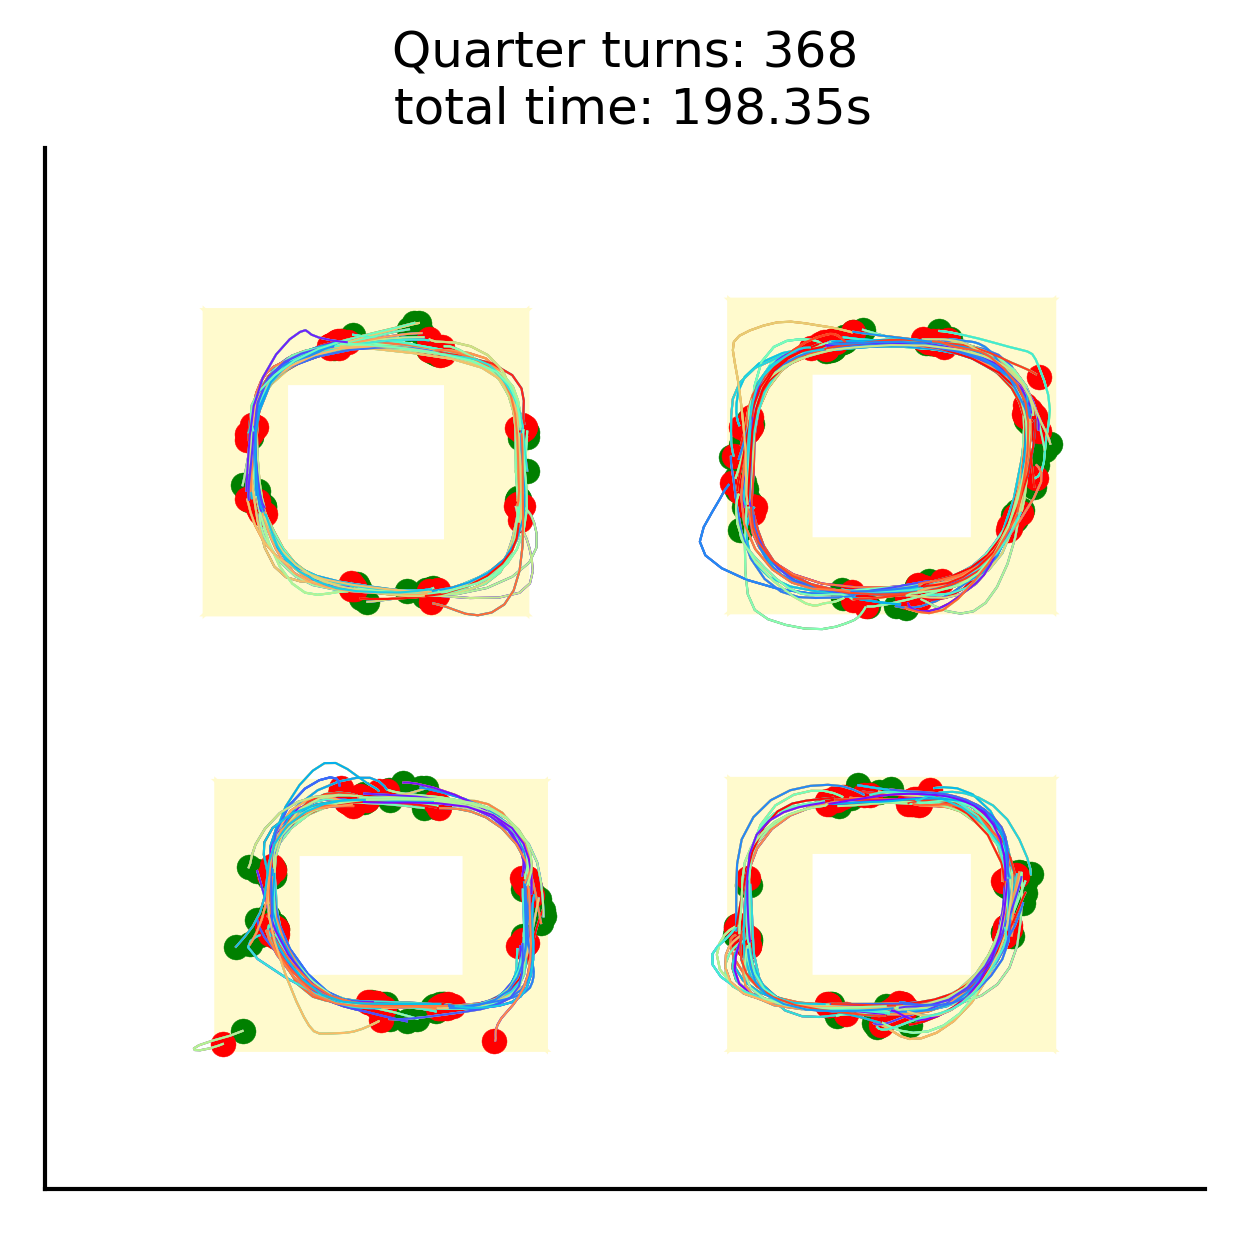

In [28]:
# Generate the figure according to analysis of cells above 
# To do : reduce the size + be able to chose which visited object number I want to look at and not all QT of the session 

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

figure_quarterturns_Maud(traj_df, list_quarter_turn, xgauss, ygauss, speed, angular_speed, acceleration, "Quarter turns: ", ax1=ax)
#plt.close()

In [ ]:
# Function to reset indexes of dataframes

def reset_index(df : DataFrame)-> DataFrame:
    """ 
    This function resets indexes of the dataframe you want
    Parameters : 
    - df : the dataframe you want to reset indexes 
    
    Returns the reset dataframe indexed from 0
    """
    reset_df = df.reset_index(drop=True)
    return reset_df

In [ ]:
# Reset les index de turns_df pour la première partie de figure

turns_df_reset = reset_index(turns_df)
print("turns_df indexes have been reset ! New Dataframe is now named : turns_df_reset \n")
print(turns_df_reset)

turns_df indexes have been reset ! New Dataframe is now named : turns_df_reset 

        time  framenumber  xposition  yposition currentPatch previousTrapeze  \
0     15.915          360         79        230           NW               W   
1     16.953          386        202        336           SW               N   
2     17.833          408        191        425           SW               E   
3     18.794          432        100        399           SW               S   
4     19.596          452         97        336           SW               W   
..       ...          ...        ...        ...          ...             ...   
667  711.526        17741        404        327           SE               E   
668  712.808        17773        412        203           NE               S   
669  713.646        17794        406        111           NE               E   
670  714.408        17813        305        105           NE               N   
671  715.527        17841        302   

In [ ]:
# Création d'un dataframe pour plotter la trajectoire de chaque objet 
# Pourquoi un nouveau df ? Parce que je veux regrouper les infos que je trouve dans 2 dataframes (turns_df et traj_df)

visited_objects = []
entrance_time = []
exit_time = []
current_patch = None

for index, row in turns_df_reset.iterrows():

    # Si c'est la première ligne ou si le current_patch a changé
    if index == 0 or row['currentPatch'] != turns_df_reset.loc[index - 1]['currentPatch']:

        # Sauvegarde du currentPatch dans la liste des objets visités
        visited_objects.append(row['currentPatch'])
        
        # Sauvegarde du temps d'entrée
        entrance_time.append(row['time'])
        
        # Si ce n'est pas la première ligne, sauvegarder le temps de sortie précédent
        if index != 0:
            exit_time.append(turns_df_reset.iloc[index - 1]['time'])
            #nb_QT.append(turns_df.iloc[index - 1]['nberOfConsecRewards'])

# Ajouter le temps de sortie pour la dernière ligne
if not turns_df_reset.empty:
    exit_time.append(turns_df_reset.iloc[-1]['time'])
    #nb_QT.append(turns_df.iloc[-1]['nberOfConsecRewards'])

# Création du DataFrame à partir des listes
# TO DO : trouver un meilleur nom pour ce dataframe...

visites_df = pd.DataFrame({
    "Visited object": visited_objects,
    "Entrance time": entrance_time,
    "Exit time": exit_time
    })

print("Your new dataframe is created as : visites_df \nYou can now know when the animal entered and got out of each object \n\n")
print(visites_df)

Your new dataframe is created as : visites_df 
You can now know when the animal entered and got out of each object 


    Visited object  Entrance time  Exit time
0               NW         15.915     15.915
1               SW         16.953     20.319
2               SE         21.035     22.517
3               NE         24.078     26.559
4               NW         27.879     30.362
..             ...            ...        ...
173             SW        673.825    675.386
174             NW        675.666    675.666
175             SW        679.588    688.314
176             SE        704.001    711.526
177             NE        712.808    715.527

[178 rows x 3 columns]


In [ ]:
# Reset les index de traj_df pour la première partie de figure

# Supprime les données de trajectoire entre 15 secondes et premier QT
traj_df = traj_df.loc[traj_df['time'] >= visites_df.iloc[0]["Entrance time"]]
#print(traj_df)

# Reset les indexes de traj_df
traj_df_reset = reset_index(traj_df)
print("traj_df indexes have been reset ! New Dataframe is now named : traj_df_reset \n")
print(traj_df_reset)

traj_df indexes have been reset ! New Dataframe is now named : traj_df_reset 

          time  xposition  yposition
0       15.915       79.0      230.0
1       15.956       85.0      244.0
2       15.994       92.0      257.0
3       16.033       97.0      271.0
4       16.075      101.0      285.0
...        ...        ...        ...
17589  719.847      462.0      267.0
17590  719.890      462.0      267.0
17591  719.930      462.0      267.0
17592  719.970      462.0      267.0
17593  720.009      462.0      267.0

[17594 rows x 3 columns]


In [ ]:
def filter_trajectory_around_time(trajectory_df : DataFrame, time_start : float, time_end : float, time_margin=1) -> DataFrame: 
    '''Cette fonction sert à ajouter un temps défini à mon temps d'entrée et de sortie 
    pour obtenir la trajectoire pendant x secondes avant et après un QT
    Return un dataframe de la trajectoire filtré
    
    This function is used to add a set time to my entry and exit time
    to obtain the trajectory for x seconds before and after a QT
    
    Parameters:
    - trajectory_df : dataframe from centroidTXY csv file
    - time_start : float representing the beginning of the movement 
    - time_end : float representing the end of the movement 
    - time_margin : defined in the function, time in seconds you want to add to your trajectory
    
    Return a filtered trajectory dataframe
    '''
    trajectory_df_filtered = trajectory_df[(trajectory_df['time'] >= (time_start - time_margin)) & (trajectory_df['time'] <= (time_end + time_margin))]
    return trajectory_df_filtered

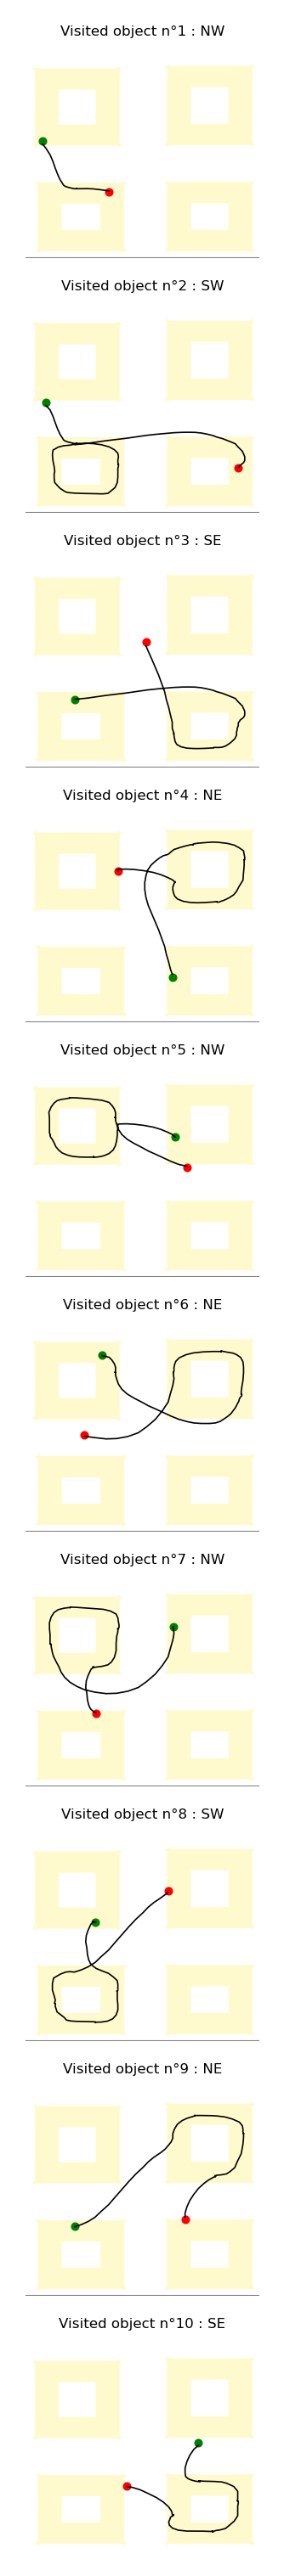

In [ ]:
# Création de la figure de la trajectoire par objet visité
# TO DO NEXT : 
# - add the second part of the figure next to the right of this one

#n=min(len(visited_objects), 10)
n=10

# Création de sous-graphiques pour chaque objet visité
fig, ax1 = plt.subplots(n, figsize=(1, 1 * n))

# Itération sur les objets visités
for i, visited_object in enumerate(visited_objects[:n]):

    # Filtrage des données de trajectoire pour l'objet visité actuel
    traj_df_filtered = filter_trajectory_around_time(traj_df_reset, visites_df.iloc[i]["Entrance time"], visites_df.iloc[i]["Exit time"])

    # Calcul des coordonnées de début et de fin de la trajectoire
    x_start = traj_df_filtered['xposition'].iloc[0]
    y_start = RESOLUTION[1] - traj_df_filtered['yposition'].iloc[0]
    x_end = traj_df_filtered['xposition'].iloc[-1]
    y_end = RESOLUTION[1] - traj_df_filtered['yposition'].iloc[-1]

    # Création du graphique de trajectoire
    ax1[i].plot(traj_df_filtered['xposition'], RESOLUTION[1] - smooth(traj_df_filtered['yposition'], TRUE_SIGMA), linewidth=0.4, c='k') # Add Resolution and True_Sigma to smooth + invert y axis
    #print(i, traj_df_filtered['xposition'].tolist())
    for patch in collection_trapeze:  #plot the trapeze around the object
        for trapeze in collection_trapeze[patch]: 
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1[i].add_patch(shape)
    ax1[i].scatter(x_start, y_start, color='green', label='Début', s=2)  # Point vert au début
    ax1[i].scatter(x_end, y_end, color='red', label='Fin', s=2)          # Point rouge à la fin
    ax1[i].set_xlim(50, 450)
    ax1[i].set_ylim(50, 450)
    ax1[i].set_title(f"Visited object n°{i+1} : {visited_object}", fontsize=4)

    # Supprime les graduations sur les axes X et Y
    ax1[i].set_xticks([])
    ax1[i].set_yticks([])
    ax1[i].axis('off') # Supprime les axes X et Y (pas juste les graduations)

    #Ajoute une ligne fine entre les subplots
    if i < n - 1 : # Ne met pas de ligne au dernier subplot
        ax1[i].axhline(y=50, color='gray', linewidth=0.5)
# Affichage des graphiques
#plt.tight_layout() # Put in comment because in matplotlib there is constrained_layout=True automatically set / does not work with tight_layout
plt.show()

In [ ]:
# Now, we try to do the same for 10 first visited objects but specifically for QT
# Below: copy of code to plot the 10 first objects global trajectory

n=10

# Création de sous-graphiques pour chaque objet visité
fig, ax2 = plt.subplots(n, figsize=(1, 1 * n))

# Itération sur les objets visités
for i, visited_object in enumerate(visited_objects[:n]):
    # Filtrage des données de trajectoire pour l'objet visité actuel
    traj_df_filtered = filter_trajectory_around_time(traj_df_reset, visites_df.iloc[i]["Entrance time"], visites_df.iloc[i]["Exit time"])

    # Calcul des coordonnées de début et de fin de la trajectoire
    x_start = traj_df_filtered['xposition'].iloc[0]
    y_start = RESOLUTION[1] - traj_df_filtered['yposition'].iloc[0]
    x_end = traj_df_filtered['xposition'].iloc[-1]
    y_end = RESOLUTION[1] - traj_df_filtered['yposition'].iloc[-1]

    # Création du graphique de trajectoire
    ax2[i].plot(traj_df_filtered['xposition'], RESOLUTION[1] - smooth(traj_df_filtered['yposition'], TRUE_SIGMA), linewidth=0.4, c='k')
    #print(i, traj_df_filtered['xposition'].tolist())
    for patch in collection_trapeze:  #plot the trapeze around the object
        for trapeze in collection_trapeze[patch]: 
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax2[i].add_patch(shape)
    ax2[i].scatter(x_start, y_start, color='green', label='Début', s=2)  # Point vert au début
    ax2[i].scatter(x_end, y_end, color='red', label='Fin', s=2)          # Point rouge à la fin
    ax2[i].set_xlim(50, 450)
    ax2[i].set_ylim(50, 450)
    ax2[i].set_title(f"Visited object n°{i+1} : {visited_object}", fontsize=4)

    # Supprime les graduations sur les axes X et Y
    ax2[i].set_xticks([])
    ax2[i].set_yticks([])
    ax2[i].axis('off') # Supprime les axes X et Y (pas juste les graduations)

    #Ajoute une ligne fine entre les subplots
    if i < n - 1 : # Ne met pas de ligne au dernier subplot
        ax2[i].axhline(y=50, color='gray', linewidth=0.5)
# Affichage des graphiques
#plt.tight_layout() # Put in comment because in matplotlib there is constrained_layout=True automatically set / does not work with tight_layout
plt.show()


# Copy of the code that generates the unique plot for QT of all session 

figure_quarterturns_Maud(traj_df, list_quarter_turn, xgauss, ygauss, speed, angular_speed, acceleration, "Quarter turns: ", ax2=ax)

In [ ]:
print(list_quarter_turn)

NameError: name 'list_quarter_turn' is not defined